In [1]:
###### Config #####
import sys, os, platform
if os.path.isdir("ds-assets"):
  !cd ds-assets && git pull
else:
  !git clone https://github.com/lutzhamel/ds-assets.git
colab = True if 'google.colab' in os.sys.modules else False
system = platform.system() # "Windows", "Linux", "Darwin"
home = "ds-assets/assets/"
sys.path.append(home)

Already up to date.


In [2]:
# modules needed
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from dsutils import plot_elbow
from dsutils import classification_confint
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Handwritten Digit Recognition

This is based on the NIST optical character dataset available at [UCI](https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits).

The dataset consist of 8x8 pixel images of handwritten digits:

<center>

![image](https://scipy-lectures.org/_images/sphx_glr_plot_digits_simple_classif_001.png)

</center>

The images themselves are stored as **pixel vectors of length 64**.  Each pixel is an integer value indicating a gray scale value.

We will build two models of the data:

1. A **clustering model** using kmeans -- to see if the digits forms a recoverable cluster structure in 64 dimensional space.

1. A **classification model** using decision trees -- to see if we can use the features in 64 dimensional space to classify the handwritten digits.

# The NIST Character Dataset

In [3]:
# fetch dataset
digits = pd.read_csv(home+'optdigits.csv', header=None)
digits.columns = ['a'+str(i) for i in range(1,65)] + ['digit']


In [4]:
digits

,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,...,a56,a57,a58,a59,a60,a61,a62,a63,a64,digit
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,6,14,7,1,0,0,0
1,0,0,10,16,6,0,0,0,0,7,...,0,0,0,10,16,15,3,0,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,9,14,0,0,0,0,7
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,1,15,2,0,0,4
4,0,0,5,14,4,0,0,0,0,0,...,0,0,0,4,12,14,7,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5615,0,0,4,10,13,6,0,0,0,1,...,0,0,0,2,14,15,9,0,0,9
5616,0,0,6,16,13,11,1,0,0,0,...,0,0,0,6,16,14,6,0,0,0
5617,0,0,1,11,15,1,0,0,0,0,...,0,0,0,2,9,13,6,0,0,8
5618,0,0,2,10,7,0,0,0,0,0,...,0,0,0,5,12,16,12,0,0,9


In [5]:

# data
X = digits.drop(columns=['digit'])
y = digits[['digit']]

In [6]:
X

,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,...,a55,a56,a57,a58,a59,a60,a61,a62,a63,a64
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,0,6,14,7,1,0,0
1,0,0,10,16,6,0,0,0,0,7,...,3,0,0,0,10,16,15,3,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,0,9,14,0,0,0,0
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,0,1,15,2,0,0
4,0,0,5,14,4,0,0,0,0,0,...,12,0,0,0,4,12,14,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5615,0,0,4,10,13,6,0,0,0,1,...,4,0,0,0,2,14,15,9,0,0
5616,0,0,6,16,13,11,1,0,0,0,...,1,0,0,0,6,16,14,6,0,0
5617,0,0,1,11,15,1,0,0,0,0,...,0,0,0,0,2,9,13,6,0,0
5618,0,0,2,10,7,0,0,0,0,0,...,2,0,0,0,5,12,16,12,0,0


**Observation**: The integer values in the feature matrix are grey values.

In [7]:
y

,digit
0,0
1,0
2,7
3,4
4,6
...,...
5615,9
5616,0
5617,8
5618,9


**Observation**: The target field is the digit described by the image.

In [8]:
y.value_counts()

digit
3        572
1        571
4        568
7        566
9        562
5        558
6        558
2        557
0        554
8        554
Name: count, dtype: int64

**Observation**: All digits are represented pretty evenly.

## Look at the First Five Digits as Images

In [9]:
y.head(n=5)

,digit
0,0
1,0
2,7
3,4
4,6


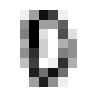

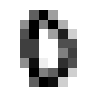

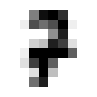

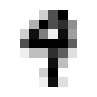

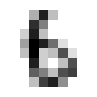

In [10]:
for i in range(5):
  im = np.array(X.iloc[i,]).reshape(8,8)
  plt.figure(figsize = (4,1))
  plt.axis('off')
  plt.imshow(im, cmap=plt.cm.binary, interpolation='nearest')
  plt.show()

# The Cluster Model

Given that there are 10 digits we would expect to see 10 clusters in the 64 dimensional space.  Let's check that with the elbow method.

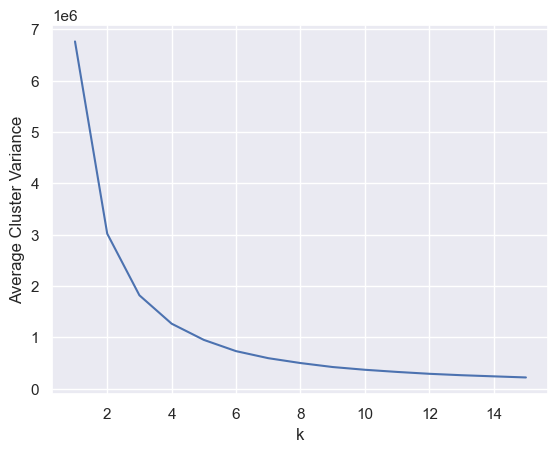

In [11]:
plot_elbow(X, n=15)

**Observation**: We can see that k=10 is at the upper end of the "elbow".

## The Kmeans Model

Now, we know that we want to compute a cluster model with,

In [12]:
k=10

under the assumption that **each cluster centroid will represent one of the digits**.

Let's try it.

In [13]:
model = KMeans(n_clusters=k,
               random_state=1)
model.fit(X)
model.cluster_centers_.shape

(10, 64)

As expected, we have 10 centroids embedded in the 64 dimensional space of the training data.

## Visualizing the Centroids

Recall that each point in the 64 dimensional space represents a handwritten digit.  That means, each of the cluster centroids has to represent a digit.  We can check that by reshaping the 1-dimensional coordinate vectors of the centroids into 8x8 bit maps.

In [14]:
# let's check the data type of the centroids
type(model.cluster_centers_[0,])

numpy.ndarray

In [15]:
# centroids are vectors
model.cluster_centers_[0,].shape

(64,)

In [16]:
cluster_digit_images =[]

In [17]:
# reshaping the centroid vectors into 8x8 bit maps
for i in range(k):
  cluster_digit_images.append(model.cluster_centers_[i,].reshape(8,8))

In [18]:
cluster_digit_images[0].shape

(8, 8)

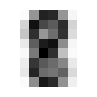

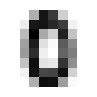

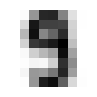

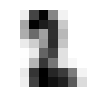

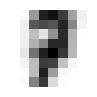

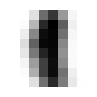

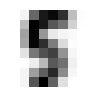

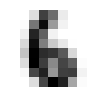

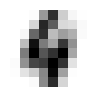

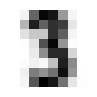

In [19]:
# display the images of the centroids
for i in range(k):
  plt.figure(figsize = (4,1))
  plt.axis('off')
  plt.imshow(cluster_digit_images[i], cmap=plt.cm.binary, interpolation='nearest')
  plt.show()

**Observation**: All the digits are clearly readable with the exception for the one which represent the digit 8.  Also, note that none of the digits are missing or repeated.

# Digit Classification

We will build a classification model based on decision trees.

In [20]:
# setting up training/testing data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.8,
    test_size=0.2,
    random_state=1
)

## The Decision Tree Model

In [21]:
model = DecisionTreeClassifier(random_state=1)

In [22]:
# find optimal model
param_grid = {
    'max_depth': list(range(1,21)), # search 1..20
    'criterion': ['entropy', 'gini', 'log_loss']
    }
grid = GridSearchCV(model, param_grid, cv=5).fit(X_train,y_train)
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'criterion': 'entropy', 'max_depth': 10}


In [23]:
# compute the accuracy of optimal model
predict_y = grid.best_estimator_.predict(X_test)
acc = accuracy_score(y_test, predict_y)
lb,ub = classification_confint(acc, X_test.shape[0])
print("Accuracy of best classifier: {:.2f} ({:.2f}, {:.2f})".format(acc, lb, ub))

Accuracy of best classifier: 0.92 (0.90, 0.93)


In [24]:
# build and print the confusion matrix
cm = pd.DataFrame(data=confusion_matrix(y_test, predict_y))
cm

,0,1,2,3,4,5,6,7,8,9
0,104,0,0,0,0,0,0,1,0,0
1,0,120,1,2,2,0,0,0,1,4
2,1,1,80,2,0,0,0,1,4,2
3,0,0,0,108,0,3,0,1,1,5
4,0,1,0,0,103,1,0,2,1,0
5,0,0,1,2,0,88,0,0,0,5
6,1,0,1,0,0,1,108,0,1,0
7,0,2,4,1,2,0,0,119,2,0
8,1,2,7,1,0,3,1,0,102,4
9,1,1,1,6,2,2,0,0,1,99


In [25]:
y_test.value_counts()

digit
1        130
7        130
8        121
3        118
9        113
6        112
4        108
0        105
5         96
2         91
Name: count, dtype: int64